
# Bac369
# Loan Approval Decisions


## Motivation
- Loans are hard to determine
- Loan approval can be a key factor in financial success (or ruin)
- Personally interested in starting a business some day, looking for insight
- Seems like an interesting way to use ML models we have learned
- Uses categorical and numerical data to reach decisions
- Large Data Set, but not too cumbersome for training
- Involves a bit of feature engineering


## Goals
Using historical data about whether loans were fully paid off or charged off, find a model to most accurately predict whether or not a loan should be approved and disbursed or not.  
Analyzed why the a particular models perform better for the problem above.
Postulate on how improvements to the models or my thought processes could improve.
Achieve better performance than dataset implies   
Target value MIS_Status with PIF and CHGOFF if loan was paid off or defaulted
P I F     361524 :  CHGOFF     98583  =  460107 total 
Aim for higher than  79% accuracy for classification


## Models
- Stochastic Gradient Descent: Elasticnet, L1, L2
- Logistic Regression: L1, L2
- Decision Tree: Gini Depth 3 and 10, Entropy Depth 3, Adaboost
- Multi-layer Perceptron
- Gradient Descent
- Tensorflow: Binary CrossEntropy



In [1]:
# Imports
import warnings; warnings.simplefilter('ignore')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from tensorflow import keras 

import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD,Adam

In [3]:
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from matplotlib import pyplot as plt

import graphviz
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'

In [5]:

# Importing Dataset and Assigning Names to Columns
''
df = pd.read_csv('SBAnational.csv')
#df.columns = []

# df =df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


### Checking Columns

In [6]:
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

### Removing Unnecessary columns
- 'LoanNr_ChkDgt', 'Name' irrelevant 
- 'City', 'Zip', 'Bank' too specific to be of use, back might be useful but hard to preprocess well.
- 'ChgOffDate', 'BalanceGross', 'ChgOffPrinGr', 'SBA_Appv' only relevant after a chargeoff, not to determine whether it will be charged off

In [7]:
df.drop(columns=['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank', \
                      'ChgOffDate', 'BalanceGross', 'ChgOffPrinGr'], inplace=True)

In [8]:
df['NAICS_Industry'] = df['NAICS'].astype('str').apply(lambda x: x[:2])

df['NAICS_Industry'] = df['NAICS_Industry'].map({
    '11': ' Agriculture_forestry_fishing_hunting',
    '21': 'Mining_quarrying_oil_gas',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Transportation_warehousing',
    '49': 'Transportation_warehousing',
    '51': 'Information',
    '52': 'Finance_Insurance',
    '53': 'Realestate_rental_leasing',
    '54': 'Professional_scientific_technicalservices',
    '55': 'Managementofcompanies_enterprises',
    '56': ' Administrative_support_wastemanagement_remediation',
    '61': 'Educational',
    '62': 'Healthcare_socialassistance',
    '71': 'Arts_entertainment_recreation',
    '72': 'Accommodation_foodservices',
    '81': 'Other',
    '92': 'Public_administration'
})
df.dropna(subset=['NAICS_Industry'], inplace=True)
df.drop(columns=['NAICS'], inplace=True)
df.shape

(697216, 19)

In [9]:
df.loc[(df['FranchiseCode'] <= 1), 'Franchise'] = 0
df.loc[(df['FranchiseCode'] > 1), 'Franchise'] = 1
df.drop(columns=['FranchiseCode'], inplace=True)

In [10]:
df.isnull().sum()

State                   8
BankState             625
ApprovalDate            0
ApprovalFY              0
Term                    0
NoEmp                   0
NewExist              136
CreateJob               0
RetainedJob             0
UrbanRural              0
RevLineCr            2338
LowDoc               2582
DisbursementDate     1955
DisbursementGross       0
MIS_Status           1716
GrAppv                  0
SBA_Appv                0
NAICS_Industry          0
Franchise               0
dtype: int64

# Preprocessing
To precprocess the data there are some objectives:
1. Identify which variables need to be cleaned: NAICS  (North American Industry Classification System) has my different values only the first two numbers are necessary to determine the industry, NewExist (whether the comaony is new or existing) has 3 values, 0, 1, 2, only 1 and 2 are relevant values, LowDocs has values that are data entry and null values
2. Change monetary values to floats without '$' or ','.
4. OneHotEncode non-numerical values: State, BankState, Industry
5. Identifying relationships between columns: State and Bank State have a relationship, I should make a new colum to identify that.
5. Encode Dates: convert to DateTime
6. Change remaining object type data to processable data.

In [11]:
df.dropna(subset=['MIS_Status'], inplace=True)

In [12]:
df.UrbanRural.unique()

array([0, 1, 2], dtype=int64)

In [13]:
df.LowDoc.unique()


array(['Y', 'N', 'C', '1', nan, 'S', 'R', 'A', '0'], dtype=object)

In [14]:
df.RevLineCr.unique()

array(['N', 'Y', '0', 'T', '`', ',', nan, '1', 'C', '2', 'R', '7', 'A',
       '-', 'Q'], dtype=object)

removing non-"Y or N" values

In [15]:
df = df[(df['RevLineCr'] == 'Y') | (df['RevLineCr'] == 'N')]
df = df[(df['LowDoc'] == 'Y') | (df['LowDoc'] == 'N')]

In [16]:
df.shape

(460107, 19)

In [17]:
#pd.set_option('display.max_columns', None)
#df = df.drop(df[df['Cancelled'] == 1].index)
#df['DATE'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=df[['DayofMonth']]))
#df.tail()

In [18]:
df[['DisbursementGross', 'GrAppv', 'SBA_Appv']] = df[['DisbursementGross', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

In [19]:
df['SameState'] = np.where(df['State'] == df['BankState'], 1, 0)

In [20]:
df.dtypes

State                 object
BankState             object
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
MIS_Status            object
GrAppv                object
SBA_Appv              object
NAICS_Industry        object
Franchise            float64
SameState              int32
dtype: object

Changing Types of Columns

In [21]:
df = df.astype({ 'UrbanRural': 'str', 'DisbursementGross': 'float', 'SBA_Appv': 'float', 'GrAppv': 'float', 'ApprovalFY': 'int64', 'Franchise' : 'float64'})

In [22]:
df.dtypes

State                 object
BankState             object
ApprovalDate          object
ApprovalFY             int64
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
UrbanRural            object
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross    float64
MIS_Status            object
GrAppv               float64
SBA_Appv             float64
NAICS_Industry        object
Franchise            float64
SameState              int32
dtype: object

In [23]:
df.ApprovalFY.unique()

array([1997, 2006, 1998, 1999, 2000, 2001, 2003, 2004, 2005, 1984, 2007,
       1987, 2008, 1988, 2009, 1989, 1990, 2010, 1991, 2011, 1992, 2002,
       2012, 1993, 2013, 1994, 2014, 1995, 1996], dtype=int64)

In [24]:
df['MIS_Status'].value_counts()

P I F     361524
CHGOFF     98583
Name: MIS_Status, dtype: int64

To LabelEncode
LowDoc , RevLineCr

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Label encoding symbolic values
le = LabelEncoder()
df[['LowDoc', 'UrbanRural', 'RevLineCr', 'MIS_Status']]=df[['LowDoc', 'UrbanRural', 'RevLineCr', 'MIS_Status']].apply(le.fit_transform)
#df = df.drop(columns = ['address'])
#X = df.iloc[:, :29]
#y = df.iloc[:, 29]

df.head()

,State,BankState,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,GrAppv,SBA_Appv,NAICS_Industry,Franchise,SameState
0,IN,OH,28-Feb-97,1997,84,4,2.0,0,0,0,0,1,28-Feb-99,60000.0,1,60000.0,48000.0,Retail_trade,0.0,0
1,IN,IN,28-Feb-97,1997,60,2,2.0,0,0,0,0,1,31-May-97,40000.0,1,40000.0,32000.0,Accommodation_foodservices,0.0,1
2,IN,IN,28-Feb-97,1997,180,7,1.0,0,0,0,0,0,31-Dec-97,287000.0,1,287000.0,215250.0,Healthcare_socialassistance,0.0,1
5,CT,DE,28-Feb-97,1997,120,19,1.0,0,0,0,0,0,30-Jun-97,517000.0,1,517000.0,387750.0,Manufacturing,0.0,0
7,FL,AL,28-Feb-97,1997,84,1,2.0,0,0,0,0,1,30-Jun-98,45000.0,1,45000.0,36000.0,Other,0.0,0


In [26]:
df['MIS_Status'].value_counts()

1    361524
0     98583
Name: MIS_Status, dtype: int64

In [27]:
df.Franchise.unique()

array([0., 1.])

In [28]:
df[['ApprovalDate', 'DisbursementDate']] = df[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)

df.drop(columns=['ApprovalDate', 'DisbursementDate'], inplace=True)

In [29]:
df.dtypes

State                 object
BankState             object
ApprovalFY             int64
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
UrbanRural             int32
RevLineCr              int32
LowDoc                 int32
DisbursementGross    float64
MIS_Status             int32
GrAppv               float64
SBA_Appv             float64
NAICS_Industry        object
Franchise            float64
SameState              int32
dtype: object

In [30]:
df.isnull().sum()

State                  8
BankState            611
ApprovalFY             0
Term                   0
NoEmp                  0
NewExist             129
CreateJob              0
RetainedJob            0
UrbanRural             0
RevLineCr              0
LowDoc                 0
DisbursementGross      0
MIS_Status             0
GrAppv                 0
SBA_Appv               0
NAICS_Industry         0
Franchise              0
SameState              0
dtype: int64

In [31]:
df.shape

(460107, 18)

In [32]:
df =df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [33]:
df.isnull().sum()

State                0
BankState            0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
MIS_Status           0
GrAppv               0
SBA_Appv             0
NAICS_Industry       0
Franchise            0
SameState            0
dtype: int64

In [34]:
df.shape

(459359, 18)

In [35]:
# One-hot encode categorical data
df = pd.get_dummies(df)

df.head()

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,...,NAICS_Industry_Manufacturing,NAICS_Industry_Mining_quarrying_oil_gas,NAICS_Industry_Other,NAICS_Industry_Professional_scientific_technicalservices,NAICS_Industry_Public_administration,NAICS_Industry_Realestate_rental_leasing,NAICS_Industry_Retail_trade,NAICS_Industry_Transportation_warehousing,NAICS_Industry_Utilities,NAICS_Industry_Wholesale_trade
0,1997,84,4,2.0,0,0,0,0,1,60000.0,...,0,0,0,0,0,0,1,0,0,0
1,1997,60,2,2.0,0,0,0,0,1,40000.0,...,0,0,0,0,0,0,0,0,0,0
2,1997,180,7,1.0,0,0,0,0,0,287000.0,...,0,0,0,0,0,0,0,0,0,0
5,1997,120,19,1.0,0,0,0,0,0,517000.0,...,1,0,0,0,0,0,0,0,0,0
7,1997,84,1,2.0,0,0,0,0,1,45000.0,...,0,0,1,0,0,0,0,0,0,0


In [36]:
df.dtypes

ApprovalFY                                     int64
Term                                           int64
NoEmp                                          int64
NewExist                                     float64
CreateJob                                      int64
                                              ...   
NAICS_Industry_Realestate_rental_leasing       uint8
NAICS_Industry_Retail_trade                    uint8
NAICS_Industry_Transportation_warehousing      uint8
NAICS_Industry_Utilities                       uint8
NAICS_Industry_Wholesale_trade                 uint8
Length: 140, dtype: object

In [37]:
df.tail()

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,...,NAICS_Industry_Manufacturing,NAICS_Industry_Mining_quarrying_oil_gas,NAICS_Industry_Other,NAICS_Industry_Professional_scientific_technicalservices,NAICS_Industry_Public_administration,NAICS_Industry_Realestate_rental_leasing,NAICS_Industry_Retail_trade,NAICS_Industry_Transportation_warehousing,NAICS_Industry_Utilities,NAICS_Industry_Wholesale_trade
899145,1997,60,5,1.0,0,0,0,1,0,25000.0,...,0,0,0,0,0,0,0,0,0,0
899146,1997,240,8,1.0,4,0,0,0,0,189000.0,...,1,0,0,0,0,0,0,0,0,0
899157,1997,36,40,1.0,0,0,0,0,0,200000.0,...,1,0,0,0,0,0,0,0,0,0
899160,1997,60,6,1.0,0,0,0,1,0,85000.0,...,0,0,0,0,0,0,1,0,0,0
899161,1997,108,26,1.0,0,0,0,0,0,300000.0,...,1,0,0,0,0,0,0,0,0,0


In [38]:
df['MIS_Status'].value_counts()

1    360798
0     98561
Name: MIS_Status, dtype: int64

## Testing

In [39]:
X= df.iloc[:, df.columns != 'MIS_Status']
y = df.iloc[:, df.columns.get_loc('MIS_Status')]
X.tail()

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,...,NAICS_Industry_Manufacturing,NAICS_Industry_Mining_quarrying_oil_gas,NAICS_Industry_Other,NAICS_Industry_Professional_scientific_technicalservices,NAICS_Industry_Public_administration,NAICS_Industry_Realestate_rental_leasing,NAICS_Industry_Retail_trade,NAICS_Industry_Transportation_warehousing,NAICS_Industry_Utilities,NAICS_Industry_Wholesale_trade
899145,1997,60,5,1.0,0,0,0,1,0,25000.0,...,0,0,0,0,0,0,0,0,0,0
899146,1997,240,8,1.0,4,0,0,0,0,189000.0,...,1,0,0,0,0,0,0,0,0,0
899157,1997,36,40,1.0,0,0,0,0,0,200000.0,...,1,0,0,0,0,0,0,0,0,0
899160,1997,60,6,1.0,0,0,0,1,0,85000.0,...,0,0,0,0,0,0,1,0,0,0
899161,1997,108,26,1.0,0,0,0,0,0,300000.0,...,1,0,0,0,0,0,0,0,0,0


### Checking for Co-Linearity

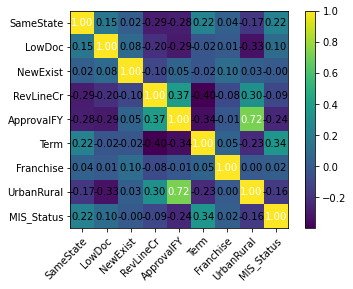

In [40]:
cols = ['SameState', 'LowDoc', 'NewExist', 'RevLineCr', 'ApprovalFY', 
              'Term', 'Franchise', 'UrbanRural', 'MIS_Status']

#scatterplotmatrix(df[cols].values, figsize=(10, 8), 
 #                 names=cols, alpha=0.5)
# plt.tight_layout()
plt.show()
cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)

plt.show()

In [41]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_std = sc.fit_transform(X)

In [42]:
from sklearn.model_selection import train_test_split

# splitting encoded data 80-20

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.2, random_state=1)

## Testing

In [43]:
lr_sgd = SGDClassifier(
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_sgd.fit(X_train, y_train)
print('Training Accuracy:',lr_sgd.score(X_train, y_train))
print('Testing Accuracy:',lr_sgd.score(X_test, y_test))

coef_SGD = pd.DataFrame(abs(lr_sgd.coef_), 
            columns=X.columns).transpose() \
            .sort_values(axis='index', by=0, ascending=False)
print(coef_SGD[0:])

Training Accuracy: 0.7890836954776631
Testing Accuracy: 0.790414925113201
                     0
Term          2.400121
BankState_GU  0.793031
GrAppv        0.481311
BankState_AN  0.475601
SameState     0.472739
...                ...
State_KY      0.000000
State_NY      0.000000
BankState_SD  0.000000
BankState_IA  0.000000
State_VA      0.000000

[139 rows x 1 columns]


In [44]:
lr_sgd = SGDClassifier(
    penalty = 'l2',
    n_jobs = -1,
    random_state = 42
)

lr_sgd.fit(X_train, y_train)
print('Training Accuracy:',lr_sgd.score(X_train, y_train))
print('Testing Accuracy:',lr_sgd.score(X_test, y_test))

coef_SGD = pd.DataFrame(abs(lr_sgd.coef_), 
            columns=X.columns).transpose() \
            .sort_values(axis='index', by=0, ascending=False)
print(coef_SGD[0:])

Training Accuracy: 0.8606780648022924
Testing Accuracy: 0.8618295019157088
                                    0
Term                         2.408664
BankState_AN                 0.659841
BankState_GU                 0.467442
NoEmp                        0.462233
SameState                    0.420033
...                               ...
State_KY                     0.003986
NAICS_Industry_Construction  0.003833
State_MN                     0.003352
State_TN                     0.003332
BankState_CO                 0.002292

[139 rows x 1 columns]


In [45]:
lr_sgd = SGDClassifier(
    penalty = 'l1',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_sgd.fit(X_train, y_train)
print('Training Accuracy:',lr_sgd.score(X_train, y_train))
print('Testing Accuracy:',lr_sgd.score(X_test, y_test))

coef_SGD = pd.DataFrame(abs(lr_sgd.coef_), 
            columns=X.columns).transpose() \
            .sort_values(axis='index', by=0, ascending=False)
print(coef_SGD[0:])

Training Accuracy: 0.8166873930234266
Testing Accuracy: 0.8187695924764891
                      0
BankState_GU  57.565341
BankState_AN   4.745228
Term           2.514925
ApprovalFY     0.479173
SameState      0.408081
...                 ...
State_NJ       0.000000
State_NE       0.000000
BankState_PR   0.000000
BankState_CT   0.000000
BankState_SD   0.000000

[139 rows x 1 columns]


In [46]:
lr = LogisticRegression(n_jobs=-1, random_state=0 )
lr.fit(X_train, y_train)

print('Training Accuracy:',lr.score(X_train, y_train))
print('Testing Accuracy:',lr.score(X_test, y_test))
print('Converge Iterations:',lr.n_iter_[0])

Training Accuracy: 0.8537934675240213
Testing Accuracy: 0.855451062347614
Converge Iterations: 48


In [47]:
coef_logreg2 = pd.DataFrame(abs(lr.coef_), 
            columns=X.columns).transpose() \
            .sort_values(axis='index', by=0, ascending=False)
print(coef_logreg2[0:])

                                   0
Term                        2.702279
SameState                   0.526829
ApprovalFY                  0.485728
RevLineCr                   0.296330
NoEmp                       0.285027
...                              ...
State_DE                    0.001842
Franchise                   0.001397
State_KY                    0.001272
BankState_SD                0.000765
NAICS_Industry_Information  0.000494

[139 rows x 1 columns]


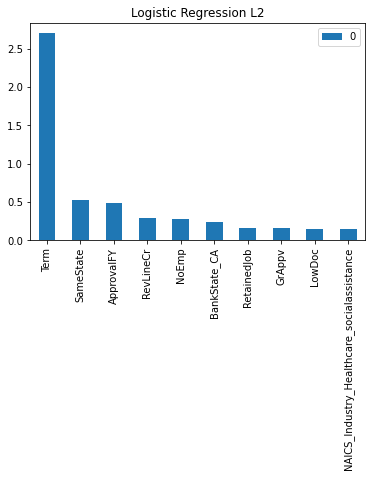

In [48]:
plot_logreg2 = coef_logreg2[0:10].xs([0], axis=1)
p1 = plot_logreg2.plot(kind='bar', title='Logistic Regression L2')

In [49]:
lr1 = LogisticRegression(penalty = 'none',C = 10.0, n_jobs=-1, random_state=0)
lr1.fit(X_train, y_train)


print('Training Accuracy:',lr1.score(X_train, y_train))
print('Testing Accuracy:',lr1.score(X_test, y_test))
print('Converge Iterations:',lr1.n_iter_[0])

Training Accuracy: 0.8537907463393263
Testing Accuracy: 0.8554401776384535
Converge Iterations: 48


In [50]:
coef_logreg1 = pd.DataFrame(abs(lr1.coef_), 
            columns=X.columns).transpose() \
            .sort_values(axis='index', by=0, ascending=False)
print(coef_logreg1[0:])

                                   0
Term                        2.702752
SameState                   0.526897
ApprovalFY                  0.485770
RevLineCr                   0.296367
NoEmp                       0.285351
...                              ...
State_DE                    0.001845
Franchise                   0.001402
State_KY                    0.001271
BankState_SD                0.000768
NAICS_Industry_Information  0.000495

[139 rows x 1 columns]


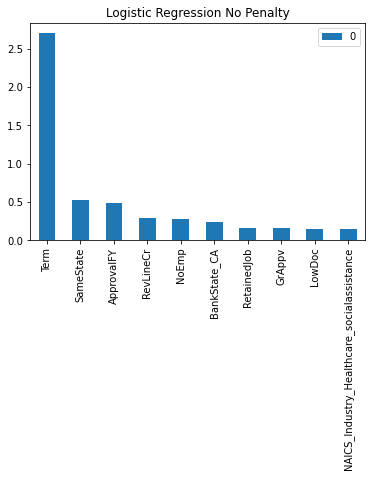

In [51]:
plot_logreg1 = coef_logreg1[0:10].xs([0], axis=1)
p1 = plot_logreg1.plot(kind='bar', title='Logistic Regression No Penalty')

In [52]:
lr2 = LogisticRegression(penalty = 'l2', solver ='liblinear',C = 1.0, n_jobs=-1, random_state=0)
lr2.fit(X_train, y_train)


print('Training Accuracy:',lr2.score(X_train, y_train))
print('Testing Accuracy:',lr2.score(X_test, y_test))
print('Converge Iterations:',lr2.n_iter_[0])

Training Accuracy: 0.8537907463393263
Testing Accuracy: 0.8554837164750958
Converge Iterations: 7


In [53]:
coef_logreg2 = pd.DataFrame(abs(lr2.coef_), 
            columns=X.columns).transpose() \
            .sort_values(axis='index', by=0, ascending=False)
print(coef_logreg2[0:])

                                   0
Term                        2.701991
SameState                   0.526796
ApprovalFY                  0.485735
RevLineCr                   0.296344
NoEmp                       0.284062
...                              ...
State_DE                    0.001840
Franchise                   0.001400
State_KY                    0.001269
BankState_SD                0.000770
NAICS_Industry_Information  0.000495

[139 rows x 1 columns]


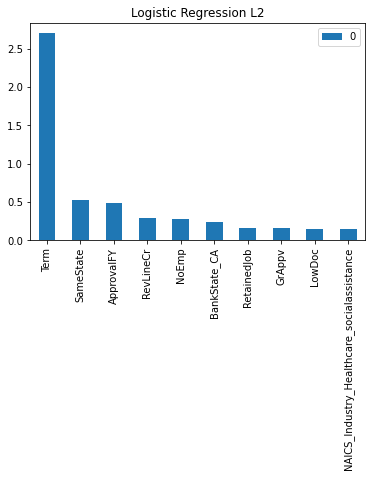

In [54]:
plot_logreg2 = coef_logreg2[0:10].xs([0], axis=1)
p2 = plot_logreg2.plot(kind='bar', title='Logistic Regression L2')

In [55]:
feature_names = df.columns[df.columns != 'MIS_Status']
class_names = ['0','1']

# Decision Trees

In [56]:
# Decision Tree classifier with criteria - Gini Index
tree_gini_1 = DecisionTreeClassifier(criterion = "gini", random_state = 50,
                               max_depth=3, min_samples_leaf=5)
tree_gini_1.fit(X_train, y_train)

y_pred_gini_1 = tree_gini_1.predict(X_test)
y_pred_gini_1_train = tree_gini_1.predict(X_train)

# Accuracy for Decision Tree classifier with criterion as gini index
print("Testing Accuracy for Decision Tree with criteria as Gini Index is: ", accuracy_score(y_test,y_pred_gini_1)*100)
print("Training Accuracy for Decision Tree with criteria as Gini Index is: ", accuracy_score(y_train,y_pred_gini_1_train)*100)

Testing Accuracy for Decision Tree with criteria as Gini Index is:  88.42084639498434
Training Accuracy for Decision Tree with criteria as Gini Index is:  88.31740986755993


In [57]:
graph_data = tree.export_graphviz(tree_gini_1, out_file=None, filled=True, rounded=True,
                                feature_names=feature_names,  
                                class_names=class_names)
graph = graphviz.Source(graph_data) 

# graph
my_tree = graphviz.Source(graph_data, directory ='') 
my_tree.save(filename='gini.pdf', directory='')
my_tree.render(filename='gini',directory='',view = True, format='pdf')

'gini.pdf'

In [58]:
# Decision Tree classifier with criteria - Gini Index
tree_gini_2 = DecisionTreeClassifier(criterion = "gini", random_state = 50,
                               max_depth=10, min_samples_leaf=5)
tree_gini_2.fit(X_train, y_train)

y_pred_gini_2 = tree_gini_2.predict(X_test)
y_pred_gini_2_train = tree_gini_2.predict(X_train)

# Accuracy for Decision Tree classifier with criterion as gini index
print("Testing Accuracy for Decision Tree with criteria as Gini Index is: ", accuracy_score(y_test,y_pred_gini_2)*100)
print("Training Accuracy for Decision Tree with criteria as Gini Index is: ", accuracy_score(y_train,y_pred_gini_2_train)*100)

Testing Accuracy for Decision Tree with criteria as Gini Index is:  94.34539359108325
Training Accuracy for Decision Tree with criteria as Gini Index is:  94.54266409424007


# Adaboost Gini Depth 3

In [59]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(base_estimator=tree_gini_1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)
#Predict the response with test dataset
y_pred = model.predict(X_test)
y_pred_adaboost_train = model.predict(X_train)

print("Testing Accuracy for Decision Tree with Adaboost is: ", accuracy_score(y_test,y_pred)*100)
print("Training Accuracy for Decision Tree with Adaboost is: ", accuracy_score(y_train,y_pred_adaboost_train)*100)

Testing Accuracy for Decision Tree with Adaboost is:  94.57941483803552
Training Accuracy for Decision Tree with Adaboost is:  94.63899403244196


In [60]:
# Decision Tree classifier with criteria - Entropy
tree_entropy_1 = DecisionTreeClassifier(criterion = "entropy", random_state = 50,
                                      max_depth=3, min_samples_leaf=5)
tree_entropy_1.fit(X_train, y_train)
y_pred_entropy_1 = tree_entropy_1.predict(X_test)
y_pred_entropy_1_train = tree_entropy_1.predict(X_train)

print("Accuracy for Decision Tree with criteria as Entropy is: ", accuracy_score(y_test,y_pred_entropy_1)*100)
print("Training Accuracy for Decision Tree with criteria as Entropy is: ", accuracy_score(y_train,y_pred_entropy_1_train)*100)

Accuracy for Decision Tree with criteria as Entropy is:  86.50840299547195
Training Accuracy for Decision Tree with criteria as Entropy is:  86.34672791146355


In [61]:
graph_data = tree.export_graphviz(tree_entropy_1, out_file=None, filled=True, rounded=True,
                                feature_names=feature_names,  
                                class_names=class_names)
graph = graphviz.Source(graph_data) 

# graph
#my_tree = graphviz.Source(graph_data, directory ='') 
#my_tree.save(filename='gini.pdf', directory='')
#my_tree.render(filename='gini',directory='',view = True, format='pdf')

# Multi-Layer Perceptron

In [62]:
mlp1 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

mlp1.fit(X_train, y_train)

mlp1.predict(X_test)


print('Training Accuracy:',mlp1.score(X_train, y_train))
print('Testing Accuracy:',mlp1.score(X_test, y_test))
# cannot get feature weights

Training Accuracy: 0.8991420104656763
Testing Accuracy: 0.9001981017067224


In [63]:
mlp2 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10, 2), random_state=1)

mlp2.fit(X_train, y_train)

mlp2.predict(X_test)

print('Training Accuracy:',mlp2.score(X_train, y_train))
print('Testing Accuracy:',mlp2.score(X_test, y_test))

Training Accuracy: 0.9109682791500108
Testing Accuracy: 0.9109413096482062


In [64]:
mlp_sgd1 = MLPClassifier(solver='sgd', alpha=1e-5,
                    hidden_layer_sizes=(10, 2), random_state=1)

mlp_sgd1.fit(X_train, y_train)

mlp_sgd1.predict(X_test)

print('Training Accuracy:',mlp_sgd1.score(X_train, y_train))
print('Testing Accuracy:',mlp_sgd1.score(X_test, y_test))

Training Accuracy: 0.9155262635140835
Testing Accuracy: 0.9141631835597352


In [65]:
mlp_sgd2 = MLPClassifier(solver='sgd', alpha=1e-5, learning_rate = 'adaptive',
                    hidden_layer_sizes=(10, 2), random_state=1)

mlp_sgd2.fit(X_train, y_train)

mlp_sgd2.predict(X_test)

print('Training Accuracy:',mlp_sgd2.score(X_train, y_train))
print('Testing Accuracy:',mlp_sgd2.score(X_test, y_test))

Training Accuracy: 0.9164106485399484
Testing Accuracy: 0.9150774991292233


In [66]:
mlp_sgd2 = MLPClassifier(solver='sgd', alpha=1e-5, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

mlp_sgd2.fit(X_train, y_train)

mlp_sgd2.predict(X_test)

print('Training Accuracy:',mlp_sgd2.score(X_train, y_train))
print('Testing Accuracy:',mlp_sgd2.score(X_test, y_test))

Training Accuracy: 0.9079450429539004
Testing Accuracy: 0.9083834029954719


# Gradient Boosting Classifier

In [67]:
gbc1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
print('Training Accuracy:',gbc1.score(X_train, y_train))
print('Testing Accuracy:',gbc1.score(X_test, y_test))

Training Accuracy: 0.9295648553554275
Testing Accuracy: 0.9310889063044235


In [68]:
gbc1_weights = zip(X.columns, gbc1.feature_importances_)
gbc1_weights = list(gbc1_weights)
res = sorted(gbc1_weights, key = lambda x: x[1], reverse = True)
for i in res[0:10]:
    print(i[0] + ': ' + str(i[1]))

Term: 0.8329578306829726
ApprovalFY: 0.11543529614889163
SameState: 0.017405547454649613
BankState_CA: 0.01148487613980299
BankState_NC: 0.004136310553502428
BankState_VA: 0.0037892775439823025
BankState_DE: 0.002050665446828861
NoEmp: 0.0019092576876672885
RevLineCr: 0.0017912135735621217
NAICS_Industry_Accommodation_foodservices: 0.001759236300167848


In [69]:
gbc3 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=3, random_state=0).fit(X_train, y_train)
gbc3.score(X_test, y_test)
print('Training Accuracy:',gbc3.score(X_train, y_train))
print('Testing Accuracy:',gbc3.score(X_test, y_test))
# significantly longer runtime

Training Accuracy: 0.9524336915319453
Testing Accuracy: 0.9511167711598746


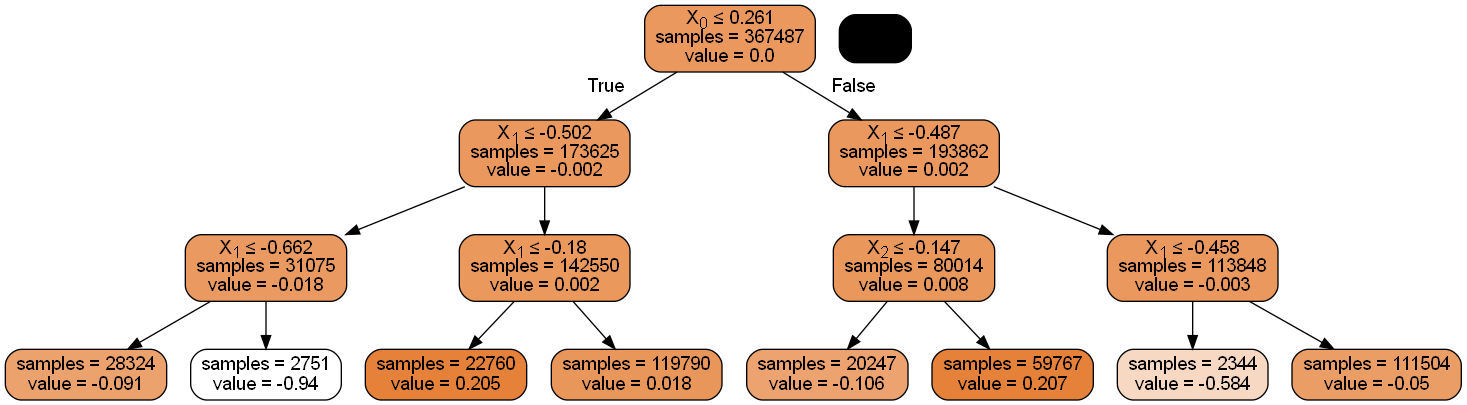

In [70]:
sub_tree_50 = gbc3.estimators_[50, 0]

# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = tree.export_graphviz(
    sub_tree_50,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())

In [71]:
gbc3_weights = zip(X.columns, gbc3.feature_importances_)
gbc3_weights = list(gbc3_weights)
res = sorted(gbc3_weights, key = lambda x: x[1], reverse = True)
for i in res[0:10]:
    print(i[0] + ' = ' + str(i[1]))

Term = 0.7566203734527538
ApprovalFY = 0.1596490114701213
SameState = 0.01652376049726722
BankState_NC = 0.012828212132501588
RevLineCr = 0.011764525441939039
BankState_CA = 0.00938040901828704
GrAppv = 0.004266257657866518
State_CA = 0.0036672269682244507
DisbursementGross = 0.002862755040344364
SBA_Appv = 0.002670953197480789


In [72]:
model = Sequential()
model.add(Dense(50,input_shape=(139,),activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))


In [73]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                7000      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,051
Trainable params: 7,051
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(Adam(lr=0.01),'binary_crossentropy',metrics=['accuracy'])


In [75]:
history = model.fit(X_train,y_train,epochs=50,shuffle=True)

Epoch 1/50
11484/11484 [==============================] - 18s 2ms/step - loss: 0.3296 - accuracy: 0.8678
Epoch 2/50
11484/11484 [==============================] - 18s 2ms/step - loss: 0.2776 - accuracy: 0.8958
Epoch 3/50
11484/11484 [==============================] - 18s 2ms/step - loss: 0.2566 - accuracy: 0.9041
Epoch 4/50
11484/11484 [==============================] - 18s 2ms/step - loss: 0.2434 - accuracy: 0.9085
Epoch 5/50
11484/11484 [==============================] - 18s 2ms/step - loss: 0.2342 - accuracy: 0.9115
Epoch 6/50
11484/11484 [==============================] - 18s 2ms/step - loss: 0.2282 - accuracy: 0.9142
Epoch 7/50
11484/11484 [==============================] - 18s 2ms/step - loss: 0.2238 - accuracy: 0.9161
Epoch 8/50
11484/11484 [==============================] - 18s 2ms/step - loss: 0.2203 - accuracy: 0.9174
Epoch 9/50
11484/11484 [==============================] - 18s 2ms/step - loss: 0.2175 - accuracy: 0.9187
Epoch 10/50
11484/11484 [==============================

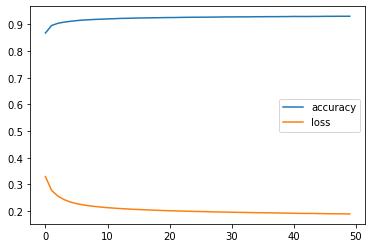

In [76]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()


In [77]:
y_hat = model.predict(X_test)


2871/2871 [==============================] - 3s 1ms/step


In [78]:
model.evaluate(X_test, y_test)


2871/2871 [==============================] - 4s 1ms/step - loss: 0.2102 - accuracy: 0.9254


[0.2101895958185196, 0.9253635406494141]

# Conclusion:   
  
  

## Logisitic Regression & Stochastic Gradient Descent
- No significant improvements from dataset baseline of 79%. 
- Not much Difference between L1 and L2 
- SGD and Logistic Regression good for linear problems
- Linear solvers may not fit problem well
- Highest Accuracy 85.5% with Logistic Regression L2 C = 1  

## Decision Trees &  Gradient Boosting Classifier  

- Good for non-linear problems
- Both yielded very good results. 
- The larger depth trees tended to perform better
- Highest accuracy GBC Depth 3 95%

## MLP & Tensorflow
- Neural Networks solutions 
- Generally performed much better than linear solver, but not as good as the decision trees
- Highest accuracy Tensorflow 93.5% binary crossentropy solver at 100 Epochs


## Improvements:
- ApprovalFY is done retroactively, if these models were used for live data it would need to be based off of projections, which likely would affect accuracy.
- Undersample might have helped: 21% of dataset charge-off
- More hidden features in dataset
- Better understanding of Loans and relationships between variables
